# 부동산 허위매물 분류 해커톤

## Data Import


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

plt.style.use('bmh')
plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/han942/vscode/refs/heads/main/datafile/dacon/fakerealestate/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/han942/vscode/refs/heads/main/datafile/dacon/fakerealestate/test.csv')
submit = pd.read_csv('https://raw.githubusercontent.com/han942/vscode/refs/heads/main/datafile/dacon/fakerealestate/sample_submission.csv')

In [3]:
train.head()

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부
0,TRAIN_0000,현장확인,402500000.0,470000,NaN,NaN,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B플랫폼,2024-10-09,0
1,TRAIN_0001,현장확인,170500000.0,200000,NaN,3.0,4.0,남동향,2.0,1.0,불가능,NaN,0,q39iV5J4E6,D플랫폼,2024-12-26,0
2,TRAIN_0002,전화확인,114000000.0,380000,NaN,2.0,3.0,동향,1.0,1.0,불가능,NaN,0,b03oE4G3F6,A플랫폼,2024-11-28,0
3,TRAIN_0003,현장확인,163500000.0,30000,36.3,3.0,9.0,남동향,2.0,1.0,가능,13.0,10,G52Iz8V2B9,A플랫폼,2024-11-26,0
4,TRAIN_0004,현장확인,346000000.0,530000,NaN,3.0,3.0,동향,2.0,1.0,불가능,NaN,0,N45gM0M7R0,B플랫폼,2024-06-25,1


In [4]:
test.head()

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일
0,TEST_000,서류확인,223000000.0,530000,NaN,5.0,5.0,남향,1.0,1.0,불가능,NaN,7,Z86Th6S3K5,D플랫폼,2024-10-21
1,TEST_001,서류확인,150500000.0,590000,30.26,7.0,11.0,서향,1.0,1.0,불가능,16.0,11,G52Iz8V2B9,D플랫폼,2023-09-02
2,TEST_002,현장확인,47000000.0,200000,41.50,2.0,3.0,남서향,2.0,1.0,불가능,NaN,0,N45gM0M7R0,B플랫폼,2024-04-03
3,TEST_003,서류확인,133000000.0,250000,31.35,5.0,6.0,남향,2.0,1.0,가능,NaN,5,C41wx1K6U9,B플랫폼,2024-09-19
4,TEST_004,현장확인,108000000.0,380000,23.14,2.0,3.0,남향,1.0,1.0,불가능,NaN,0,Z68ZJ6F6L4,A플랫폼,2024-11-10


In [5]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes,columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['%missing'] = df.isnull().sum().values / len(df) *100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    
    return summ
summary(train)

data shape: (2452, 17)


,data type,#missing,%missing,#unique,min,max
ID,object,0,0.000000,2452,NaN,NaN
매물확인방식,object,0,0.000000,3,NaN,NaN
보증금,float64,0,0.000000,426,5000000.0,409000000.0
월세,int64,0,0.000000,76,0.0,750000.0
전용면적,float64,787,32.096248,800,17.5,49.97
해당층,float64,229,9.339315,21,1.0,21.0
총층,float64,16,0.652529,20,2.0,21.0
방향,object,0,0.000000,8,NaN,NaN
방수,float64,16,0.652529,2,1.0,2.0
욕실수,float64,18,0.734095,2,1.0,2.0


In [6]:
for i in [train,test]:
    i['제공플랫폼'] = i['제공플랫폼'].apply(lambda x: x.replace('플랫폼',''))
    i['게재일'] = pd.to_datetime(i['게재일'],format='%Y-%m-%d')
    i['년'] = i['게재일'].dt.year
    i['월'] = i['게재일'].dt.month
    i['일'] = i['게재일'].dt.day
    i['요일'] = i['게재일'].dt.weekday
del train['게재일'],test['게재일']

## EDA

- 결측치 : 전용면적(연속형),해당층,총층,방수,욕실수,총주차대수
- 총층와 해당층 관련된 유사관계
- 관리비: 0의 의미

In [7]:
df_tr = train.copy()
df_te = test.copy()

df_tr = df_tr.drop('ID',axis=1)
df_te = df_te.drop('ID',axis=1)

In [8]:
con_col = ['보증금','월세','전용면적','관리비','해당층','총층','방수','욕실수','총주차대수']
cat_col = [col for col in df_tr.columns if col not in con_col]
cat_col.remove('중개사무소')
cat_col.remove('허위매물여부')

### Total Distribution

In [9]:
con_col

['보증금', '월세', '전용면적', '관리비', '해당층', '총층', '방수', '욕실수', '총주차대수']

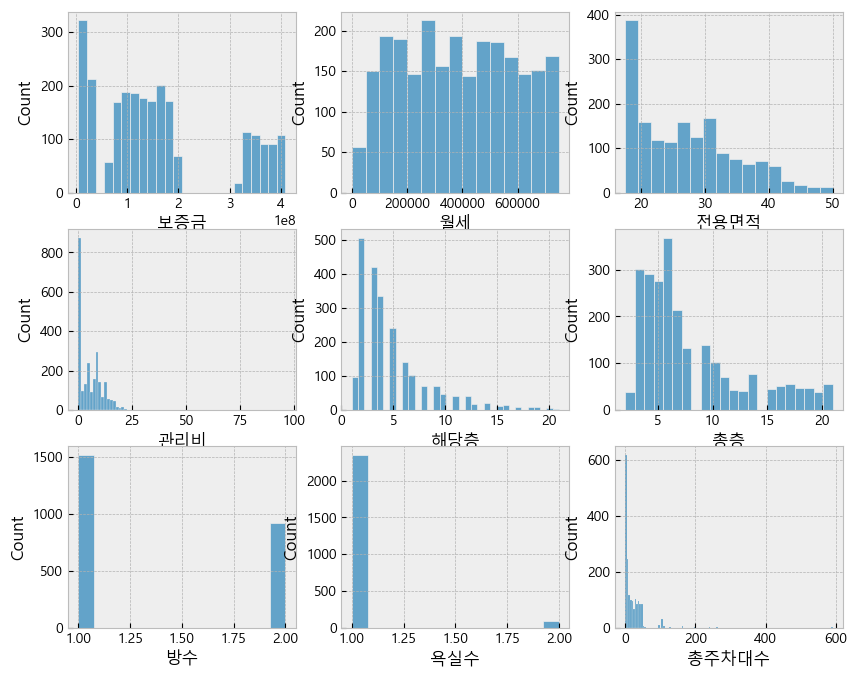

In [10]:
fig,ax = plt.subplots(3,3,figsize=(10,8))
ax = ax.flatten()

for i,col in enumerate(con_col):
    sns.histplot(df_tr[col],ax=ax[i])

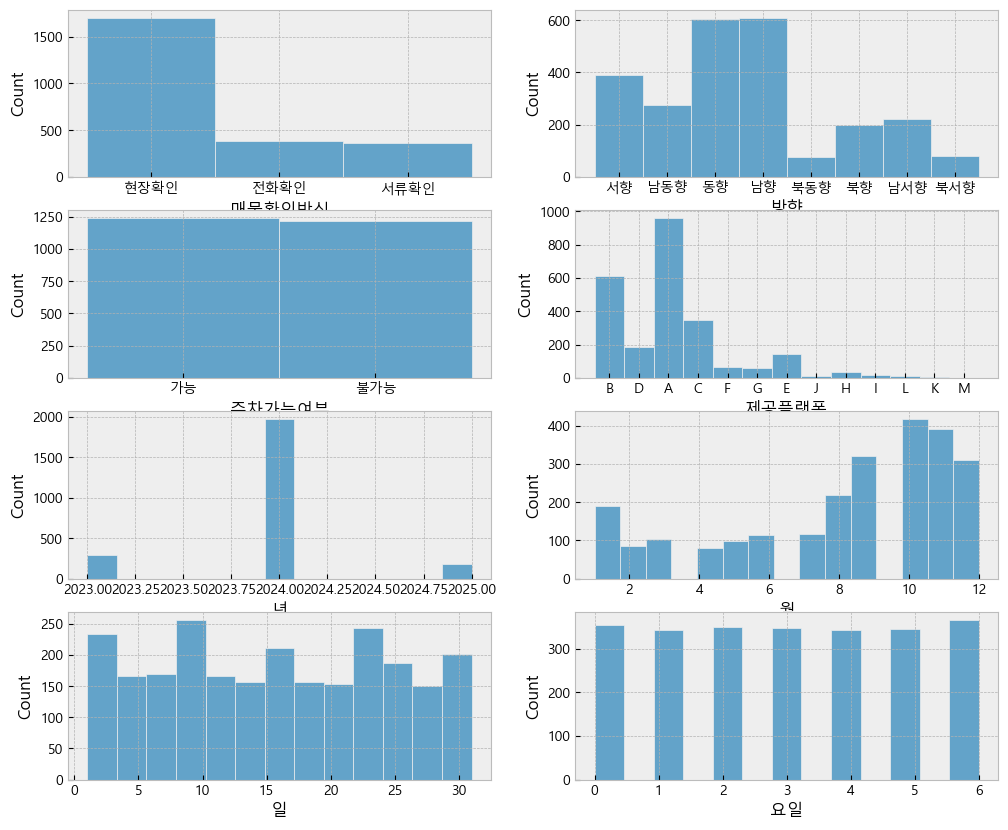

In [11]:
fig,ax = plt.subplots(4,2,figsize=(12,10))
ax = ax.flatten()

for i,col in enumerate(cat_col):
    sns.histplot(df_tr[col],ax=ax[i])

c:\Users\hanan\miniconda3\envs\jupytercode\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  func(*args, **kwargs)
c:\Users\hanan\miniconda3\envs\jupytercode\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


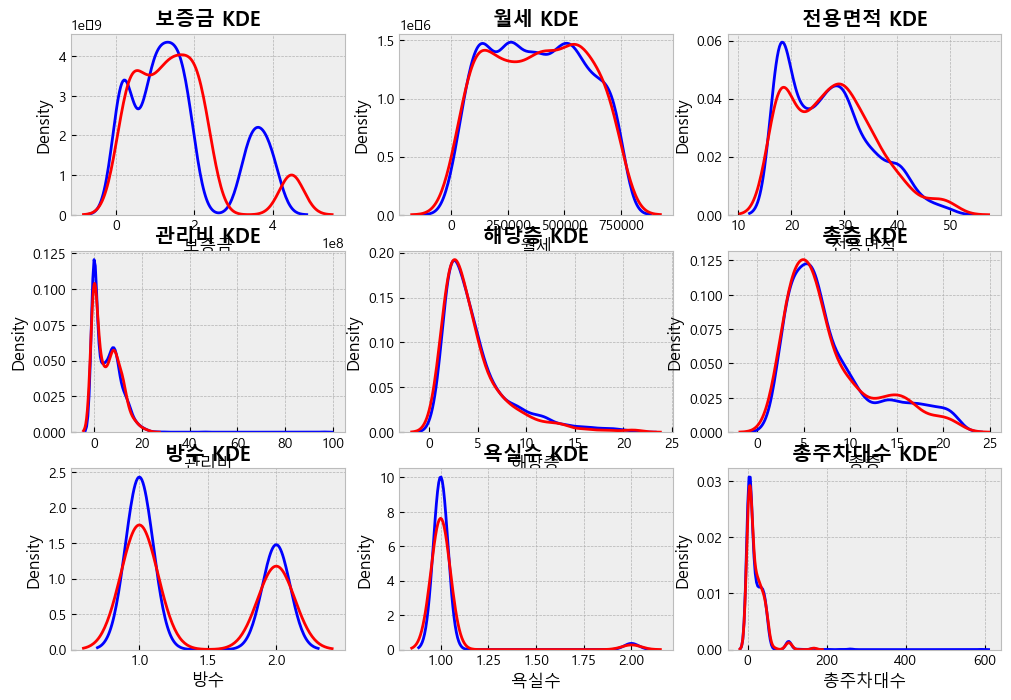

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(12,8))
ax = ax.flatten()

for i, col in enumerate(con_col):
    sns.kdeplot(data=df_tr, x=col,ax=ax[i],color='blue')
    sns.kdeplot(data=df_te,x=col,ax=ax[i],color='red')
    ax[i].set_title(f'{col} KDE',weight='bold')


c:\Users\hanan\miniconda3\envs\jupytercode\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  func(*args, **kwargs)
c:\Users\hanan\miniconda3\envs\jupytercode\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


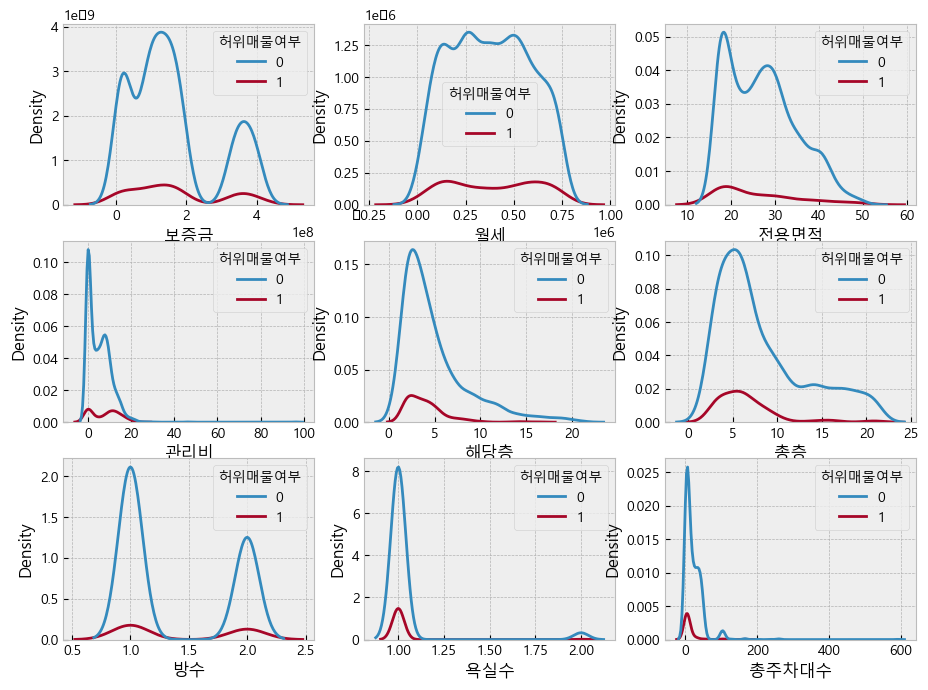

In [13]:
fig,ax = plt.subplots(3,3,figsize=(11,8))
ax = ax.flatten()

for i,col in enumerate(con_col):
    sns.kdeplot(x=df_tr[col],hue=df_tr['허위매물여부'],ax=ax[i])

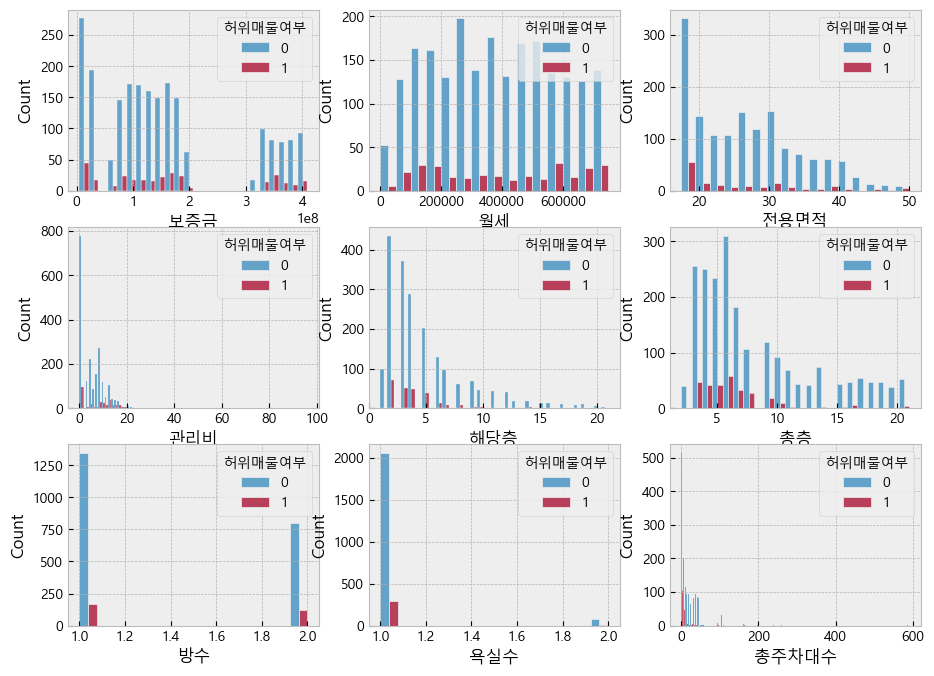

In [14]:
fig,ax = plt.subplots(3,3,figsize=(11,8))
ax = ax.flatten()

for i,col in enumerate(con_col):
    sns.histplot(x=df_tr[col],hue=df_tr['허위매물여부'],ax=ax[i],multiple='dodge')

### 1.매물 확인방식

<Axes: xlabel='매물확인방식', ylabel='Count'>

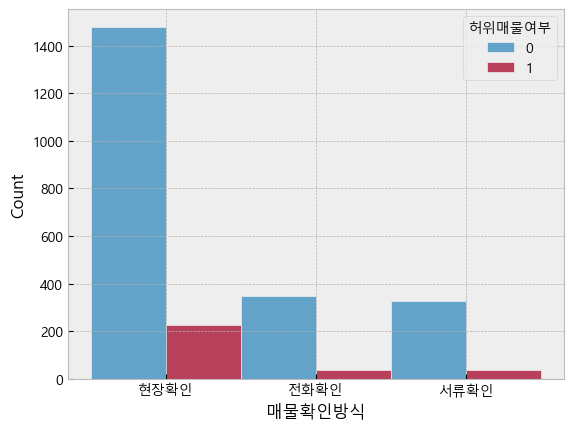

In [15]:
sns.histplot(x=df_tr['매물확인방식'],hue=df_tr['허위매물여부'],multiple='dodge')

### 2. 보증금 & 월세
- 허위매물 보증금/월세 분포도 전체 보증금/월세를 따라감 => 별다른 전처리X
- 월세와 보증금 간의 관계: 일정부분의 상관관계?
- 월세가 0인 데이터도 존재 => 이는 모두 허위매물임

In [16]:
df_tr.loc[df_tr['월세']<10000]

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,허위매물여부,년,월,일,요일
188,현장확인,5000000.0,0,NaN,4.0,4.0,동향,1.0,1.0,불가능,1.0,9,Z18up3D1C3,A,1,2024,8,27,1
725,서류확인,364000000.0,0,17.50,10.0,16.0,북동향,1.0,1.0,가능,34.0,0,R17wi5N4M8,D,1,2024,5,19,6
809,현장확인,108500000.0,0,18.87,NaN,16.0,동향,1.0,1.0,가능,54.0,0,G38pb6B9C7,C,1,2024,7,16,1
1305,현장확인,18000000.0,0,17.50,NaN,17.0,남동향,1.0,1.0,가능,99.0,0,y86qM5T6T6,A,1,2024,5,16,3


<Axes: xlabel='보증금', ylabel='Count'>

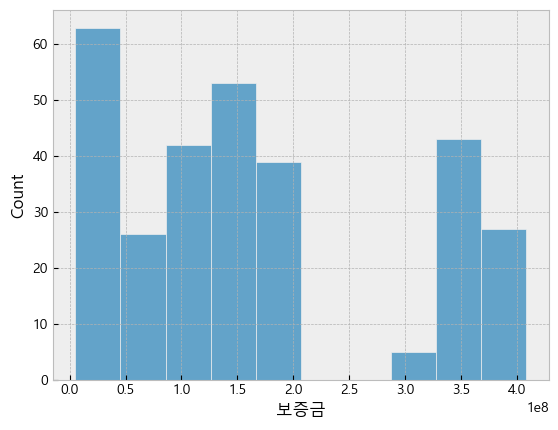

In [17]:
sns.histplot(x=df_tr['보증금'].loc[df_tr['허위매물여부']==1])

<Axes: xlabel='월세', ylabel='관리비'>

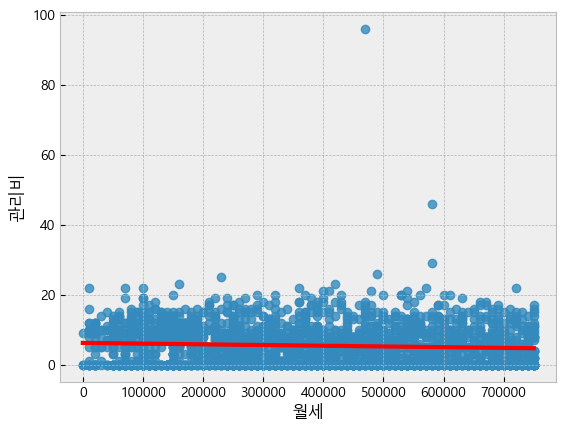

In [18]:
sns.regplot(x=df_tr['월세'],y=df_tr['관리비'],line_kws={'color':'red'})

<Axes: xlabel='월세', ylabel='보증금'>

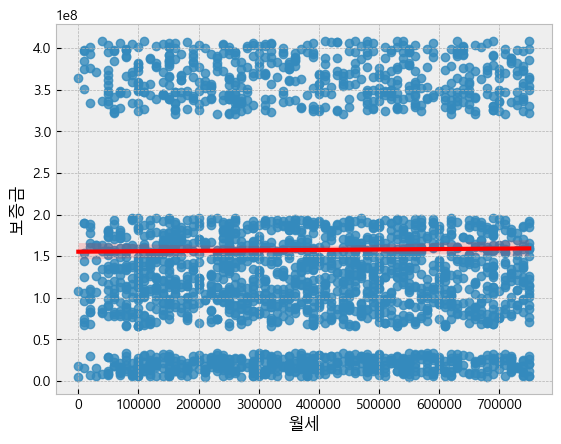

In [19]:
sns.regplot(x=df_tr['월세'],y=df_tr['보증금'],line_kws={'color':'red'})

### 3.전용면적
- 결측치가 존재 1/6정도(787개)
- 전용면적은 방의 갯수,월세,보증금 등 여럿 변수에 영향을 받는다.
- 최소면적인 17.5의 방이 300개
    - 당연하게도? 17.5인 방에 허위매물이 많음(**12%**)
    
- 월세 / 보증금과 그렇게 특이한 부분이 띄진 않음.
- 결측치 / 결측치가 아닌 data의 target 비율이 비슷함.


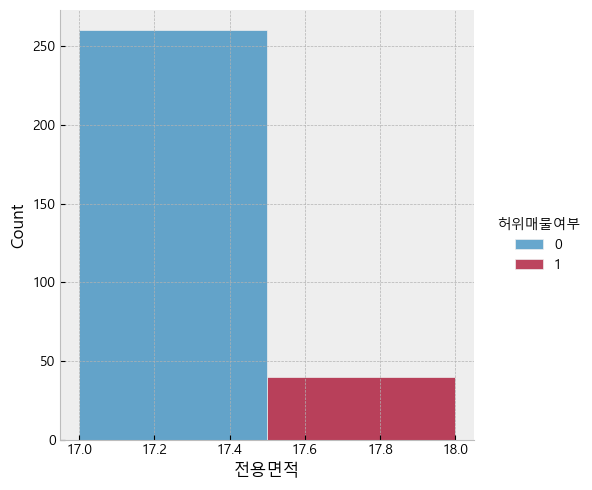

In [20]:
sns.displot(x=df_tr['전용면적'].loc[df_tr['전용면적']==17.5],hue=df_tr['허위매물여부'],multiple='dodge')

Text(0.5, 1.0, '허위매물의 전용면적 분포')

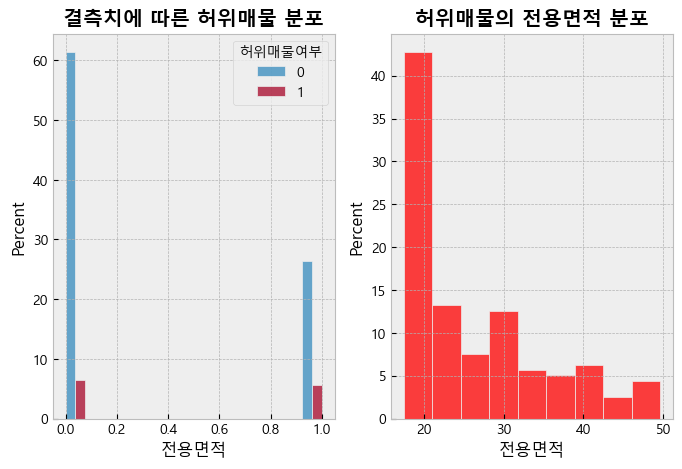

In [21]:
fig,ax = plt.subplots(1,2,figsize=(8,5))
sns.histplot(x=df_tr['전용면적'].isna(),hue=df_tr['허위매물여부'],ax=ax[0],stat='percent',multiple='dodge')
sns.histplot(df_tr['전용면적'].loc[df_tr['허위매물여부']==1], color='red', stat='percent',ax=ax[1])
ax[0].set_title('결측치에 따른 허위매물 분포',weight='bold')
ax[1].set_title('허위매물의 전용면적 분포',weight='bold')

In [22]:
df_tr.loc[df_tr['전용면적'].isna()]

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,허위매물여부,년,월,일,요일
0,현장확인,402500000.0,470000,NaN,NaN,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B,0,2024,10,9,2
1,현장확인,170500000.0,200000,NaN,3.0,4.0,남동향,2.0,1.0,불가능,NaN,0,q39iV5J4E6,D,0,2024,12,26,3
2,전화확인,114000000.0,380000,NaN,2.0,3.0,동향,1.0,1.0,불가능,NaN,0,b03oE4G3F6,A,0,2024,11,28,3
4,현장확인,346000000.0,530000,NaN,3.0,3.0,동향,2.0,1.0,불가능,NaN,0,N45gM0M7R0,B,1,2024,6,25,1
6,현장확인,348500000.0,400000,NaN,2.0,3.0,북동향,1.0,1.0,불가능,NaN,0,A72Mx9C8U2,D,0,2024,8,23,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437,현장확인,151500000.0,650000,NaN,2.0,3.0,동향,1.0,1.0,불가능,NaN,0,L27JO3N6S2,C,0,2024,12,15,6
2440,현장확인,29500000.0,420000,NaN,3.0,4.0,남동향,2.0,1.0,가능,1.0,2,u92NN7A1E5,A,0,2024,7,25,3
2443,현장확인,16500000.0,370000,NaN,4.0,9.0,남향,1.0,1.0,불가능,6.0,0,S06Ox3K4D9,A,0,2024,11,13,2
2445,현장확인,341000000.0,740000,NaN,2.0,5.0,동향,1.0,1.0,불가능,NaN,10,H90uE4C0W5,A,0,2024,10,30,2


<Axes: xlabel='전용면적', ylabel='월세'>

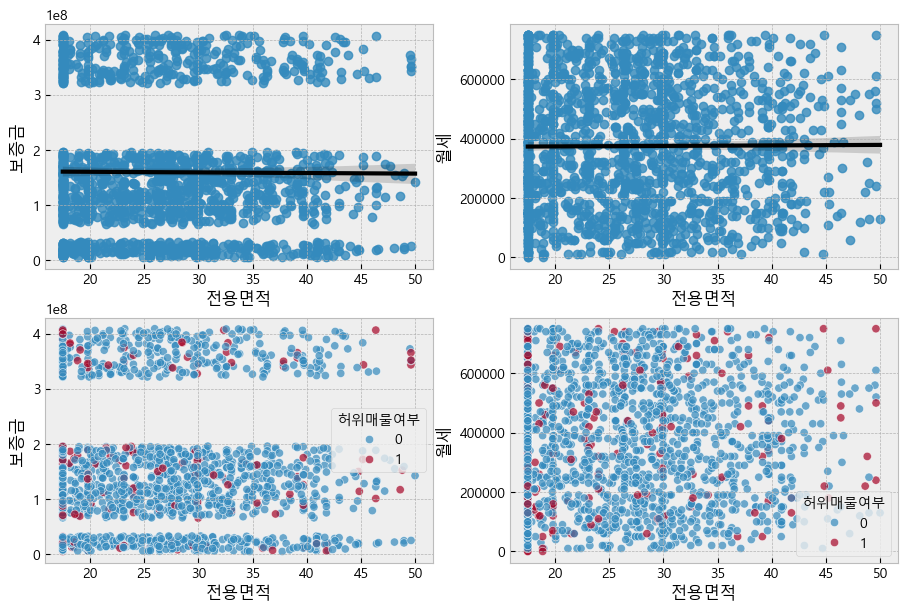

In [23]:
fig,ax = plt.subplots(2,2,figsize=(11,7))
ax=ax.flatten()
sns.regplot(x='전용면적',y='보증금',data=df_tr,line_kws={'color':'black'},ax=ax[0])
sns.regplot(x='전용면적',y='월세',data=df_tr,line_kws={'color':'black'},ax=ax[1])
sns.scatterplot(x='전용면적',y='보증금',data=df_tr,hue='허위매물여부',ax=ax[2],alpha=0.7)
sns.scatterplot(x='전용면적',y='월세',data=df_tr,hue='허위매물여부',ax=ax[3],alpha=0.7)

<Axes: xlabel='총주차대수', ylabel='전용면적'>

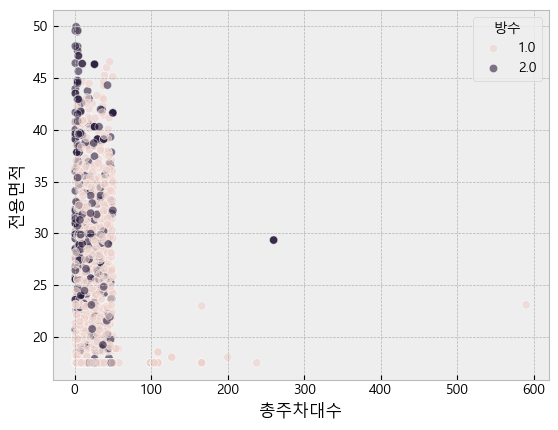

In [24]:
sns.scatterplot(x=df_tr['총주차대수'],y=df_tr['전용면적'],hue=df_tr['방수'],alpha=0.6)

### 4. 해당층 / 총층
- 해당층 // 총층의 값을 '층비율' 변수 정의로 하면 좋을듯.

- 총층이 결측치면 무조건 해당층도 결측치임. (총층:16개 / 해당층:229)
    - 총층 결측치는 삭제해도 괜찮을듯
    - 결측치 내부의 허위매물 비율도 별 특징 없는듯


In [25]:
df_tr.loc[df_tr['총층'].isna()]

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,허위매물여부,년,월,일,요일
37,현장확인,25000000.0,520000,NaN,NaN,NaN,동향,NaN,NaN,불가능,NaN,4,k74XT0T1B8,D,0,2024,10,6,6
76,전화확인,81000000.0,70000,NaN,NaN,NaN,남향,NaN,NaN,불가능,NaN,0,K48zc2G4K8,D,0,2025,1,4,5
88,현장확인,151000000.0,50000,NaN,NaN,NaN,서향,NaN,NaN,불가능,NaN,0,M02bn7Y4P0,D,0,2025,1,16,3
153,현장확인,167000000.0,380000,NaN,NaN,NaN,동향,NaN,NaN,가능,1.0,0,c14YI4Z7E6,D,0,2024,8,29,3
339,서류확인,194000000.0,360000,NaN,NaN,NaN,남향,NaN,NaN,불가능,NaN,0,M02bn7Y4P0,D,0,2025,1,13,0
456,전화확인,65500000.0,100000,NaN,NaN,NaN,북서향,NaN,NaN,가능,4.0,9,l84az9J6A2,C,0,2024,10,15,1
515,전화확인,189500000.0,500000,NaN,NaN,NaN,북서향,NaN,NaN,불가능,NaN,0,M02bn7Y4P0,D,0,2024,7,25,3
546,서류확인,116000000.0,180000,NaN,NaN,NaN,남동향,NaN,NaN,불가능,NaN,9,o07ZC4L7V4,C,0,2024,11,7,3
686,현장확인,181500000.0,520000,NaN,NaN,NaN,서향,NaN,NaN,불가능,NaN,0,M02bn7Y4P0,D,0,2024,8,15,3
952,서류확인,350000000.0,700000,NaN,NaN,NaN,남향,NaN,NaN,불가능,NaN,0,K48zc2G4K8,D,1,2024,7,3,2


Text(0.5, 1.0, '총층 분포')

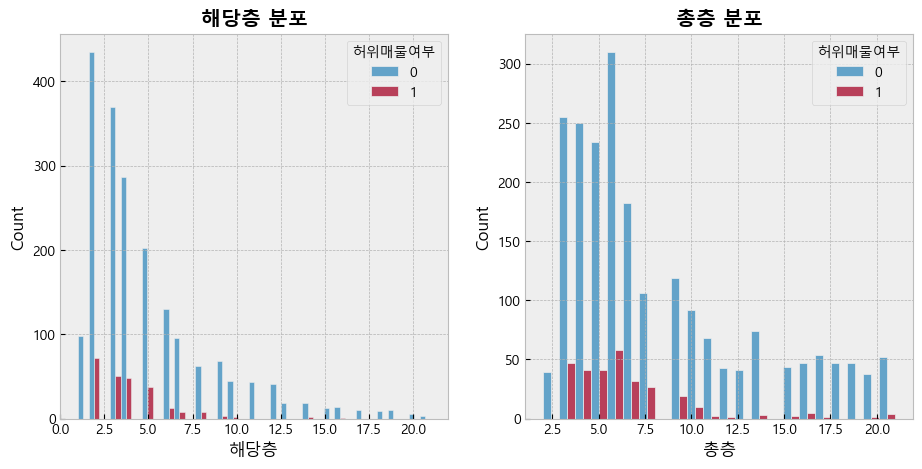

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
sns.histplot(x=df_tr['해당층'], hue=df_tr['허위매물여부'], multiple='dodge', ax=ax[0])
ax[0].set_title('해당층 분포',weight='bold')

sns.histplot(x=df_tr['총층'], hue=df_tr['허위매물여부'], multiple='dodge', ax=ax[1])
ax[1].set_title('총층 분포',weight='bold')

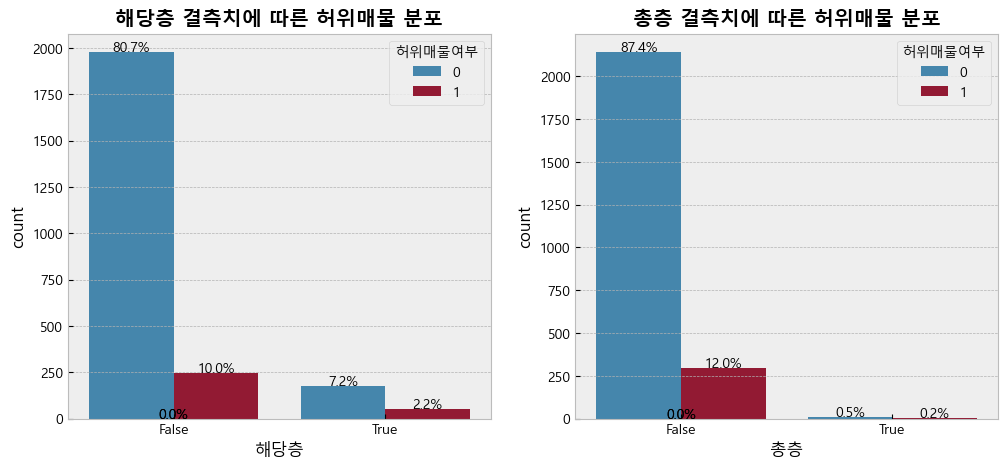

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=df_tr['해당층'].isna(), hue=df_tr['허위매물여부'], ax=ax[0])
ax[0].set_title('해당층 결측치에 따른 허위매물 분포', weight='bold')

sns.countplot(x=df_tr['총층'].isna(), hue=df_tr['허위매물여부'], ax=ax[1])
ax[1].set_title('총층 결측치에 따른 허위매물 분포', weight='bold')
# Adding percentage labels on the bars
for a in ax:
    for p in a.patches:
        height = p.get_height()
        total = len(df_tr)
        a.text(p.get_x() + p.get_width() / 2., height + 3,
               f'{height/total:.1%}', ha="center")

<Axes: xlabel='총층', ylabel='해당층'>

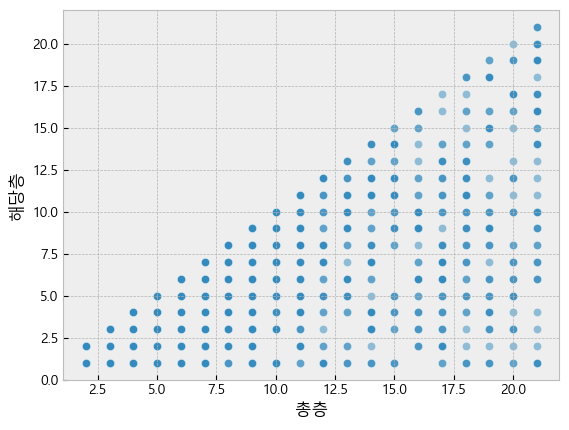

In [55]:
sns.scatterplot(data=df_tr, x='총층', y='해당층', alpha=0.5)

### 5. 방향

<Axes: xlabel='방향', ylabel='Percent'>

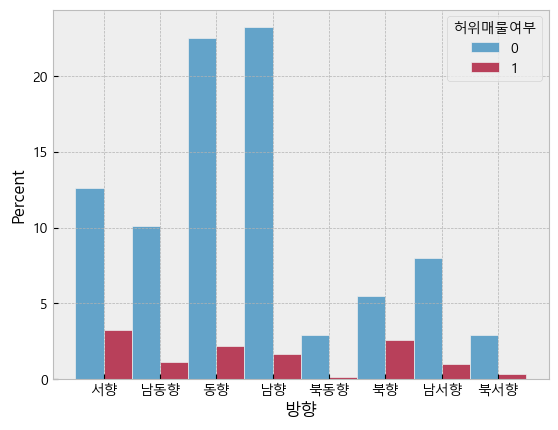

In [29]:
sns.histplot(x=df_tr['방향'],hue=df_tr['허위매물여부'],multiple='dodge',stat='percent')

### 6. 방수 / 욕실수
- 결측치가 별로 없음. (방수:16 / 욕실:18)
    - 방수,총층의 결측치(16개)가 모두 겹침(이부분은 제거하는게 맞을듯)
    - 결측치의 합집합은 1171 칼럼.
- 방 수에 따라서 허위매물에 영향을 끼치는게 있을듯. (특히 2개)

In [30]:
df_tr[['전용면적','해당층','총층','방수','욕실수','총주차대수']][df_tr.isna().any(axis=1)]

,전용면적,해당층,총층,방수,욕실수,총주차대수
0,NaN,NaN,15.0,1.0,1.0,40.0
1,NaN,3.0,4.0,2.0,1.0,NaN
2,NaN,2.0,3.0,1.0,1.0,NaN
4,NaN,3.0,3.0,2.0,1.0,NaN
5,29.50,NaN,3.0,2.0,1.0,1.0
...,...,...,...,...,...,...
2445,NaN,2.0,5.0,1.0,1.0,NaN
2446,17.50,NaN,14.0,1.0,1.0,104.0
2447,48.95,3.0,3.0,2.0,1.0,NaN
2448,NaN,2.0,4.0,1.0,1.0,NaN


In [31]:
df_tr.loc[df_tr['방수'].isna() & df_tr['총층'].isna()]

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,허위매물여부,년,월,일,요일
37,현장확인,25000000.0,520000,NaN,NaN,NaN,동향,NaN,NaN,불가능,NaN,4,k74XT0T1B8,D,0,2024,10,6,6
76,전화확인,81000000.0,70000,NaN,NaN,NaN,남향,NaN,NaN,불가능,NaN,0,K48zc2G4K8,D,0,2025,1,4,5
88,현장확인,151000000.0,50000,NaN,NaN,NaN,서향,NaN,NaN,불가능,NaN,0,M02bn7Y4P0,D,0,2025,1,16,3
153,현장확인,167000000.0,380000,NaN,NaN,NaN,동향,NaN,NaN,가능,1.0,0,c14YI4Z7E6,D,0,2024,8,29,3
339,서류확인,194000000.0,360000,NaN,NaN,NaN,남향,NaN,NaN,불가능,NaN,0,M02bn7Y4P0,D,0,2025,1,13,0
456,전화확인,65500000.0,100000,NaN,NaN,NaN,북서향,NaN,NaN,가능,4.0,9,l84az9J6A2,C,0,2024,10,15,1
515,전화확인,189500000.0,500000,NaN,NaN,NaN,북서향,NaN,NaN,불가능,NaN,0,M02bn7Y4P0,D,0,2024,7,25,3
546,서류확인,116000000.0,180000,NaN,NaN,NaN,남동향,NaN,NaN,불가능,NaN,9,o07ZC4L7V4,C,0,2024,11,7,3
686,현장확인,181500000.0,520000,NaN,NaN,NaN,서향,NaN,NaN,불가능,NaN,0,M02bn7Y4P0,D,0,2024,8,15,3
952,서류확인,350000000.0,700000,NaN,NaN,NaN,남향,NaN,NaN,불가능,NaN,0,K48zc2G4K8,D,1,2024,7,3,2


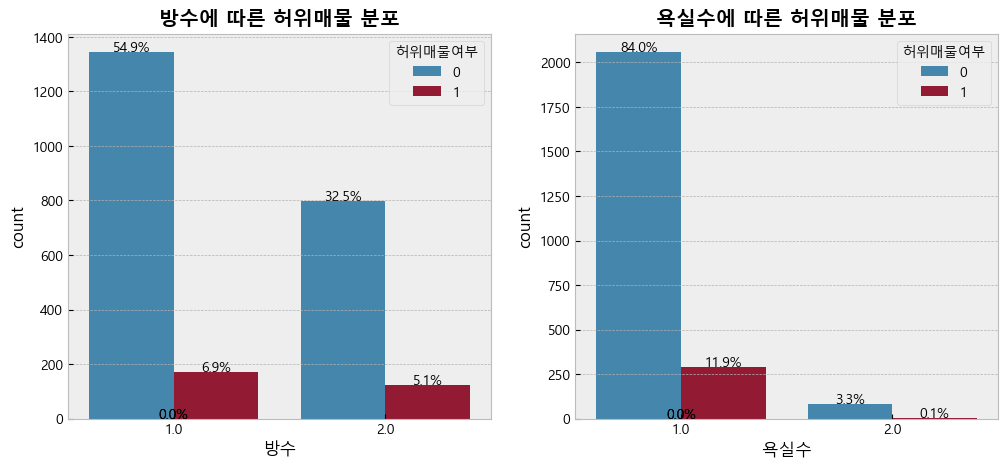

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x=df_tr['방수'], hue=df_tr['허위매물여부'], ax=ax[0])
ax[0].set_title('방수에 따른 허위매물 분포', weight='bold')

sns.countplot(x=df_tr['욕실수'], hue=df_tr['허위매물여부'], ax=ax[1])
ax[1].set_title('욕실수에 따른 허위매물 분포', weight='bold')

# Adding percentage labels on the bars
for p in ax[0].patches:
    height = p.get_height()
    total = len(df_tr)
    ax[0].text(p.get_x() + p.get_width() / 2., height + 3,
               f'{height/total:.1%}', ha="center")

for p in ax[1].patches:
    height = p.get_height()
    total = len(df_tr)
    ax[1].text(p.get_x() + p.get_width() / 2., height + 3,
               f'{height/total:.1%}', ha="center")

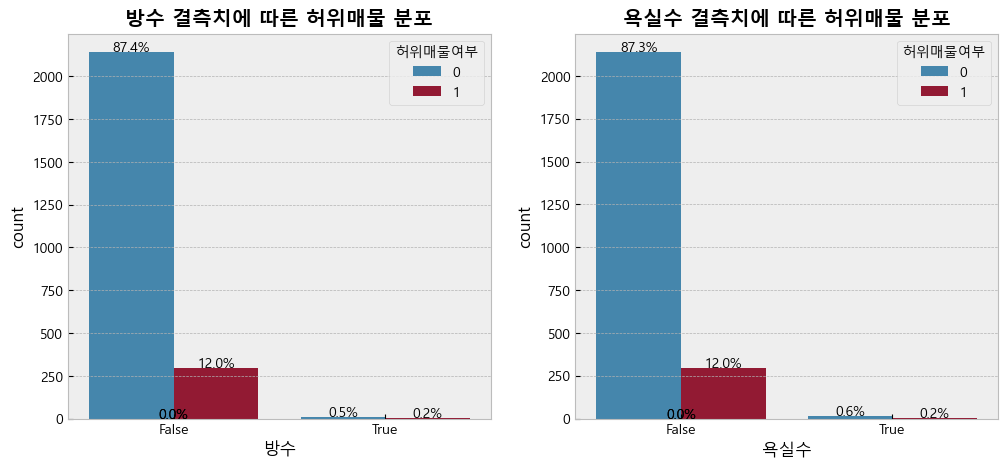

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=df_tr['방수'].isna(), hue=df_tr['허위매물여부'], ax=ax[0])
ax[0].set_title('방수 결측치에 따른 허위매물 분포', weight='bold')

sns.countplot(x=df_tr['욕실수'].isna(), hue=df_tr['허위매물여부'], ax=ax[1])
ax[1].set_title('욕실수 결측치에 따른 허위매물 분포', weight='bold')
# Adding percentage labels on the bars
for a in ax:
    for p in a.patches:
        height = p.get_height()
        total = len(df_tr)
        a.text(p.get_x() + p.get_width() / 2., height + 3,
               f'{height/total:.1%}', ha="center")

### 7.주차가능여부 / 총주차대수
- 총주차대수의 결측치에 꽤 많은 허위매물이 존재함.
- 100~300대의 주차공간이 가능한 매물 / 600개 이상의 주차공간을 가진 곳도 존재
    - 이상치로 치부할것인가? => **이상치 고려X**

- 주차가능여부가 불가능인데 총주차대수가 기록되어있는 데이터??
    - 총 데이터는 630개
    - 하지만 결측치가 있는 데이터 696개
    

In [34]:
df_tr.loc[df_tr['총주차대수'].isna()][['주차가능여부','총주차대수']]

,주차가능여부,총주차대수
1,불가능,NaN
2,불가능,NaN
4,불가능,NaN
6,불가능,NaN
7,불가능,NaN
...,...,...
2437,불가능,NaN
2445,불가능,NaN
2447,불가능,NaN
2448,불가능,NaN


In [35]:
df_tr.loc[df_tr['총주차대수'].isna()]['주차가능여부'].value_counts()

주차가능여부
불가능    585
가능     111
Name: count, dtype: int64

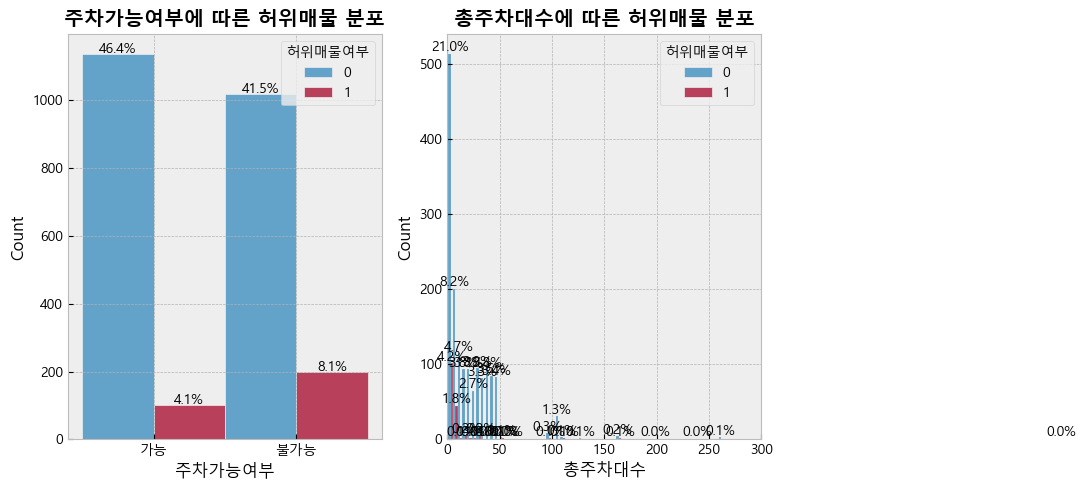

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(x=df_tr['주차가능여부'], hue=df_tr['허위매물여부'], multiple='dodge', ax=ax[0])
ax[0].set_title('주차가능여부에 따른 허위매물 분포', weight='bold')
 
sns.histplot(x=df_tr['총주차대수'], hue=df_tr['허위매물여부'], ax=ax[1],multiple='dodge')
ax[1].set_title('총주차대수에 따른 허위매물 분포', weight='bold')
ax[1].set_xlim(0,300)
# Adding percentage labels on the bars
for a in ax:
    for p in a.patches:
        height = p.get_height()
        total = len(df_tr)
        if height / total > 0.0:
            a.text(p.get_x() + p.get_width() / 2., height + 3,
               f'{height/total:.1%}', ha="center")
plt.tight_layout()

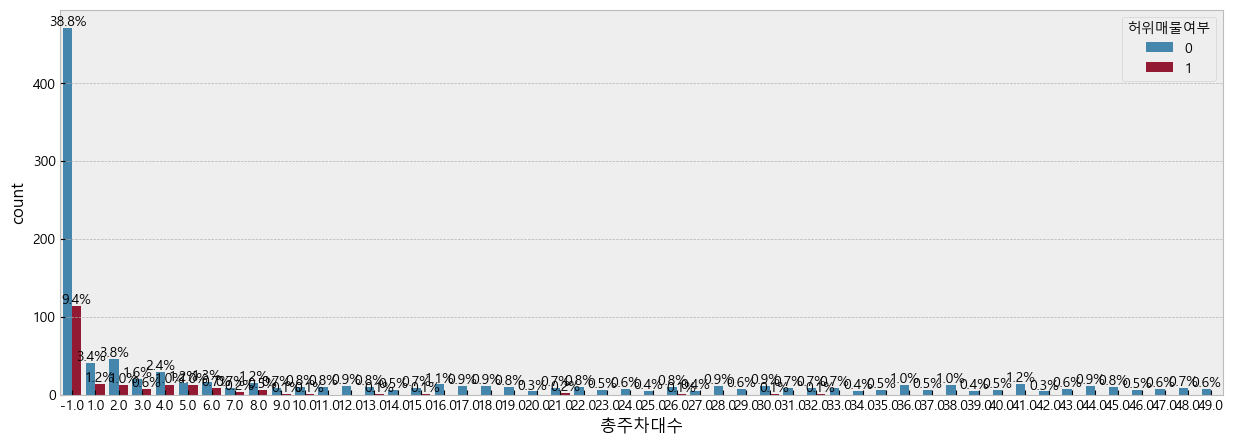

In [37]:
df_miss = df_tr.loc[(df_tr['주차가능여부']=='불가능')][['허위매물여부','총주차대수']]
df_miss.fillna(-1, inplace=True)
fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x=df_miss['총주차대수'].loc[df_miss['총주차대수']<50], hue=df_miss['허위매물여부'], ax=ax)
# Adding percentage labels on the bars
total = len(df_miss)
for p in ax.patches:
    height = p.get_height()
    if height / total > 0.0:
        ax.text(p.get_x() + p.get_width() / 2., height + 3,
                f'{height/total:.1%}', ha="center")

Text(0.5, 1.0, '허위매물의 총주차대수 분포')

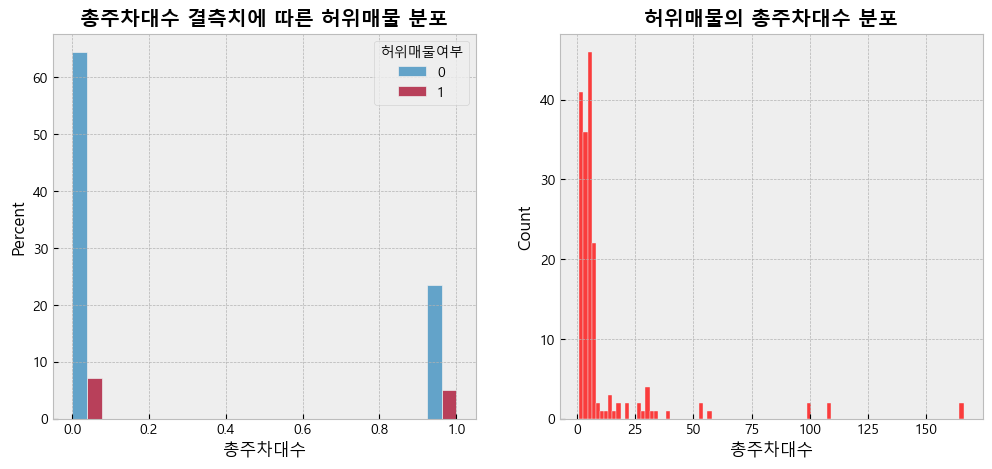

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(x=df_tr['총주차대수'].isna(), hue=df_tr['허위매물여부'], multiple='dodge', stat='percent', ax=ax[0])
ax[0].set_title('총주차대수 결측치에 따른 허위매물 분포', weight='bold')
sns.histplot(x=df_tr['총주차대수'].loc[df_tr['허위매물여부']==1], ax=ax[1],color='red')
ax[1].set_title('허위매물의 총주차대수 분포', weight='bold')

### 8. 관리비
- 관리비에 이상치가 몇개 존재하는듯
    
- 관리비가 0인 데이터가 많음 => 0의 의미?

In [39]:
print(df_tr['관리비'].loc[df_tr['허위매물여부']==1].value_counts(normalize=True)[:5])
df_tr.loc[df_tr['관리비']>20].sort_values('관리비',ascending=False)

관리비
0     0.305369
10    0.080537
13    0.067114
12    0.063758
9     0.057047
Name: proportion, dtype: float64


,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,허위매물여부,년,월,일,요일
0,현장확인,402500000.0,470000,NaN,NaN,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B,0,2024,10,9,2
518,현장확인,72500000.0,580000,NaN,3.0,5.0,남향,1.0,1.0,가능,5.0,46,Y04yg0T7Z5,B,0,2024,8,23,4
1574,현장확인,102500000.0,580000,24.01,9.0,10.0,남서향,2.0,1.0,가능,8.0,29,i23ag3Z3Y7,A,0,2024,12,13,4
2410,전화확인,14000000.0,490000,21.49,2.0,5.0,동향,1.0,1.0,가능,7.0,26,z40LO7P9C9,F,0,2024,11,27,2
1541,현장확인,33000000.0,230000,21.88,4.0,6.0,북동향,1.0,1.0,가능,8.0,25,A18IU3D9M4,B,0,2024,10,21,0
1819,전화확인,321500000.0,160000,17.50,12.0,14.0,남향,1.0,1.0,가능,104.0,23,z40LO7P9C9,F,0,2024,12,1,6
1976,현장확인,15500000.0,420000,23.14,2.0,4.0,서향,1.0,1.0,불가능,NaN,23,M02bn7Y4P0,A,1,2024,3,23,5
704,현장확인,135000000.0,720000,43.48,4.0,13.0,북향,2.0,1.0,가능,NaN,22,C41wx1K6U9,B,0,2024,9,2,0
441,전화확인,161500000.0,570000,41.65,NaN,9.0,동향,2.0,1.0,가능,50.0,22,r82ax9M3U3,B,0,2024,12,2,0
2075,현장확인,137000000.0,100000,NaN,4.0,8.0,동향,1.0,1.0,가능,3.0,22,Q39nx9D3P1,D,0,2024,9,11,2


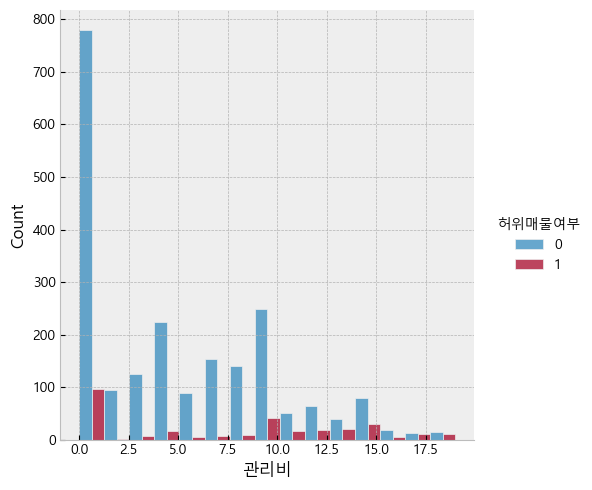

In [40]:
#0인 허위매물의 비율이 30%
sns.displot(x=df_tr['관리비'].loc[df_tr['관리비']<20],hue=df_tr['허위매물여부'],multiple='dodge')

### 9. 중개사무소 / 제공플랫폼
- 중개사무소에서 사기가 시작될 확률이 높다.
    - 특정 중개사무소에 꽤 사건이 발생했음.
    - 총 132개의 중개사무소에서 허위매물이 발생했음


In [41]:
df_tr['제공플랫폼'].value_counts()

제공플랫폼
A    958
B    610
C    350
D    184
E    142
F     63
G     59
H     34
I     20
J     12
L     10
K      8
M      2
Name: count, dtype: int64

In [42]:
#허위매물이 있는 중개사무소 이름 (허위매물이 많은 순서대로)
estate_agency = df_tr.loc[df_tr['허위매물여부']==1].value_counts(subset=['중개사무소']).to_frame().reset_index()['중개사무소'].to_list()

In [43]:
df_tr.loc[(df_tr['중개사무소'].isin(estate_agency[:2]))&(df_tr['허위매물여부']==1)]

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,허위매물여부,년,월,일,요일
229,서류확인,356000000.0,50000,39.12,NaN,14.0,남서향,2.0,1.0,가능,30.0,9,r82ax9M3U3,B,1,2024,5,29,2
241,현장확인,163000000.0,700000,26.25,3.0,7.0,서향,1.0,1.0,불가능,4.0,15,z54Fl0B2P9,A,1,2024,4,7,6
434,현장확인,92000000.0,710000,20.10,4.0,7.0,북향,1.0,1.0,불가능,2.0,8,z54Fl0B2P9,A,1,2024,4,15,0
588,현장확인,21500000.0,550000,NaN,4.0,4.0,서향,1.0,1.0,불가능,1.0,1,z54Fl0B2P9,A,1,2023,11,21,1
590,현장확인,365500000.0,490000,39.12,NaN,14.0,서향,2.0,1.0,불가능,30.0,10,r82ax9M3U3,B,1,2023,11,8,2
858,현장확인,14500000.0,250000,NaN,6.0,6.0,남동향,1.0,1.0,불가능,NaN,12,z54Fl0B2P9,A,1,2024,11,23,5
877,현장확인,140500000.0,320000,39.12,NaN,14.0,남서향,2.0,1.0,가능,30.0,10,r82ax9M3U3,B,1,2024,6,23,6
1250,현장확인,173500000.0,500000,18.54,4.0,5.0,서향,1.0,1.0,불가능,2.0,13,z54Fl0B2P9,A,1,2024,1,9,1
1274,현장확인,75500000.0,320000,24.01,NaN,10.0,남서향,2.0,1.0,가능,8.0,20,r82ax9M3U3,B,1,2024,6,26,2
1321,현장확인,354500000.0,110000,NaN,5.0,6.0,남동향,1.0,1.0,불가능,NaN,0,z54Fl0B2P9,A,1,2024,6,1,5


In [44]:
df_tr.loc[(df_tr['중개사무소']=='G52Iz8V2B9') & (df_tr['허위매물여부']==1)]

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,허위매물여부,년,월,일,요일


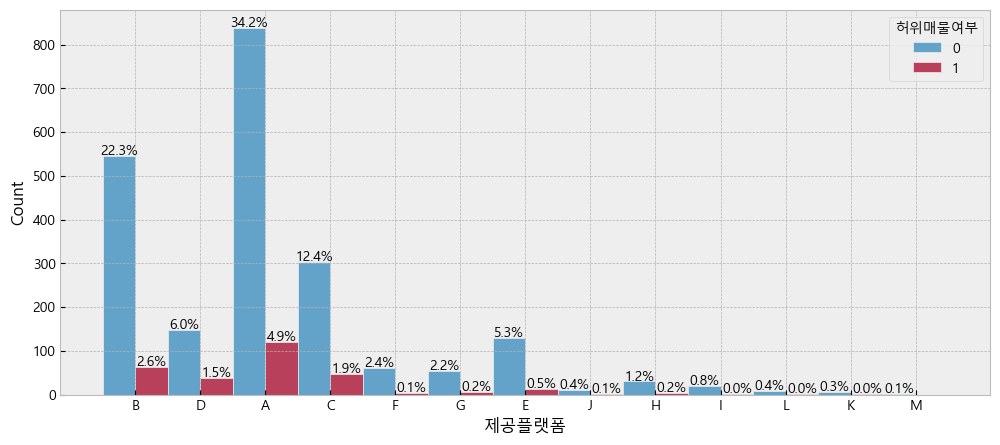

In [45]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(x=df_tr['제공플랫폼'], hue=df_tr['허위매물여부'], multiple='dodge', ax=ax)

# Adding percentage labels on the bars
total = len(df_tr)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width() / 2., height + 3,
                f'{height/total:.1%}', ha="center")

### 10. 년/월/일/요일
- 요일에 따라서는 진짜 구분이 없음. => 요일 feature 삭제 고려

Text(0.5, 1.0, '요일 분포')

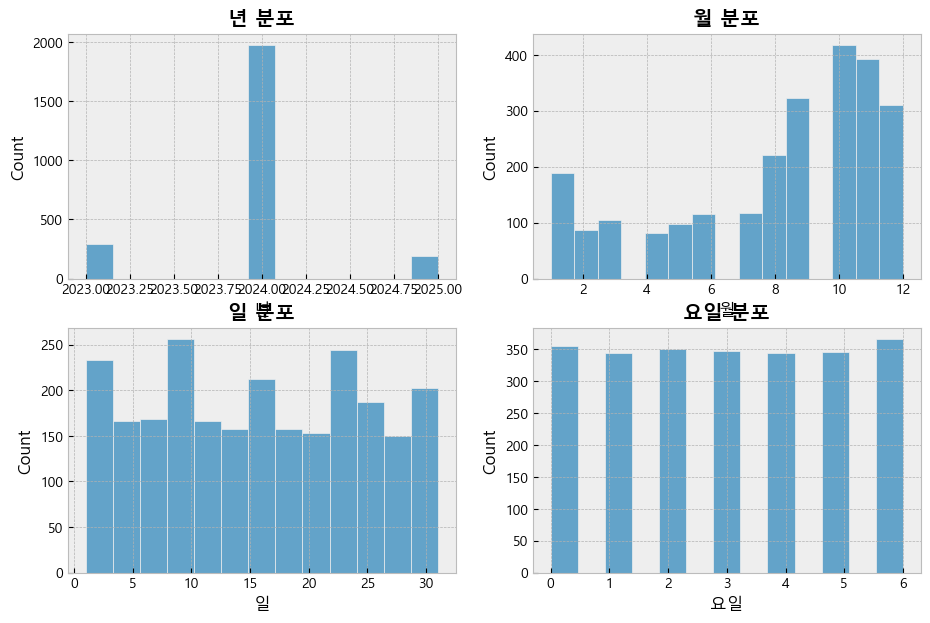

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(11, 7))
sns.histplot(df_tr['년'], ax=ax[0, 0])
ax[0, 0].set_title('년 분포', weight='bold')

sns.histplot(df_tr['월'], ax=ax[0, 1])
ax[0, 1].set_title('월 분포', weight='bold')

sns.histplot(df_tr['일'], ax=ax[1, 0])
ax[1, 0].set_title('일 분포', weight='bold')

sns.histplot(df_tr['요일'], ax=ax[1, 1])
ax[1, 1].set_title('요일 분포', weight='bold')

In [47]:
df_tr.loc[(df_tr['허위매물여부']==1)&(df_tr['월']==4)]

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,허위매물여부,년,월,일,요일
118,현장확인,11000000.0,740000,25.49,NaN,7.0,남향,1.0,1.0,가능,1.0,1,s37cv8A6L4,A,1,2024,4,19,4
136,현장확인,135000000.0,70000,NaN,4.0,6.0,서향,1.0,1.0,불가능,NaN,19,H90uE4C0W5,A,1,2024,4,19,4
241,현장확인,163000000.0,700000,26.25,3.0,7.0,서향,1.0,1.0,불가능,4.0,15,z54Fl0B2P9,A,1,2024,4,7,6
279,현장확인,336500000.0,210000,NaN,2.0,3.0,남동향,1.0,1.0,불가능,NaN,0,w85cb3W8U9,D,1,2024,4,25,3
282,현장확인,184500000.0,750000,24.01,NaN,10.0,북향,2.0,1.0,가능,8.0,16,r16Dr6Z7C3,A,1,2024,4,20,5
324,현장확인,126000000.0,340000,39.66,3.0,5.0,북향,1.0,1.0,가능,5.0,0,Z68ZJ6F6L4,A,1,2024,4,17,2
347,서류확인,145000000.0,730000,17.50,2.0,3.0,동향,2.0,1.0,불가능,NaN,0,S75yJ5K6D2,B,1,2024,4,19,4
372,현장확인,12000000.0,580000,NaN,2.0,3.0,남향,2.0,1.0,가능,1.0,9,x68FU7B0S3,B,1,2024,4,17,2
378,전화확인,77000000.0,80000,NaN,2.0,3.0,북향,2.0,1.0,불가능,NaN,7,A72Mx9C8U2,B,1,2024,4,25,3
434,현장확인,92000000.0,710000,20.10,4.0,7.0,북향,1.0,1.0,불가능,2.0,8,z54Fl0B2P9,A,1,2024,4,15,0


Text(0.5, 1.0, '요일 분포')

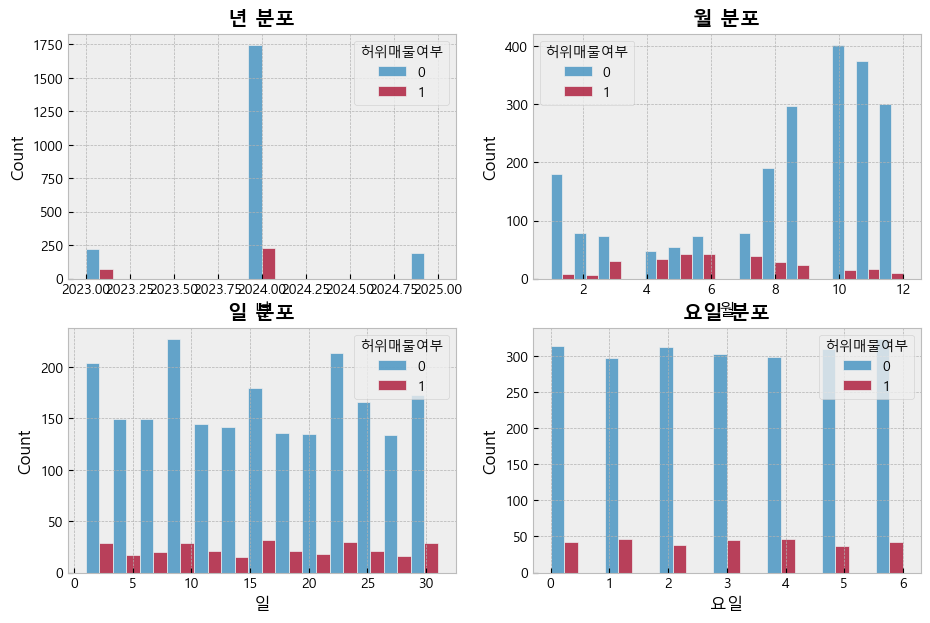

In [48]:
fig, ax = plt.subplots(2, 2, figsize=(11, 7))

sns.histplot(x=df_tr['년'], hue=df_tr['허위매물여부'], multiple='dodge', ax=ax[0, 0])
ax[0, 0].set_title('년 분포', weight='bold')

sns.histplot(x=df_tr['월'], hue=df_tr['허위매물여부'], multiple='dodge', ax=ax[0, 1])
ax[0, 1].set_title('월 분포', weight='bold')

sns.histplot(x=df_tr['일'], hue=df_tr['허위매물여부'], multiple='dodge', ax=ax[1, 0])
ax[1, 0].set_title('일 분포', weight='bold')

sns.histplot(x=df_tr['요일'], hue=df_tr['허위매물여부'], multiple='dodge', ax=ax[1, 1])
ax[1, 1].set_title('요일 분포', weight='bold')


c:\Users\hanan\miniconda3\envs\jupytercode\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()


<Axes: >

c:\Users\hanan\miniconda3\envs\jupytercode\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  func(*args, **kwargs)
c:\Users\hanan\miniconda3\envs\jupytercode\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


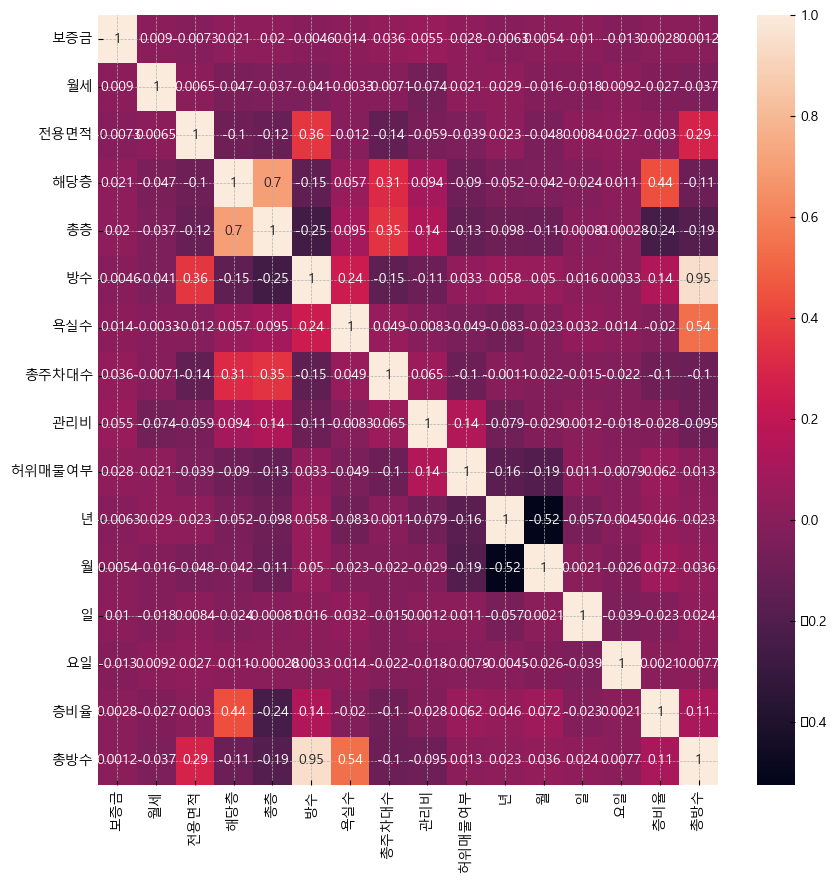

In [58]:
plt.figure(figsize=(10,10))
sns.heatmap(df_tr.corr(numeric_only=True),annot=True)

## Feature Engineering
- 파생변수 생성
    - 해당층 // 총층

- 결측치 16개 삭제
- 요일 column 삭제 (rf은 높게나옴)

In [ ]:
df_tr['층비율'] = df_tr['해당층'] / df_tr['총층']
df_te['층비율'] = df_te['해당층'] / df_te['총층']
print(df_tr.shape)

(2452, 20)


(2452, 21)

#전용면적 결측치 보간
df_tr['전용면적'] = df_tr['전용면적'].fillna(df_tr['전용면적'].mean())
df_tr['전용면적'].isna().sum()

In [ ]:
#결측치 16개 삭제
df_tr = df_tr.dropna(subset=['방수'],axis=0)
print(df_tr.shape)

In [ ]:
df_tr = df_tr.drop(columns=['요일'],axis=1)
df_te = df_te.drop(columns=['요일'],axis=1)
print(df_tr.shape)

cat_col.remove('요일')
cat_col.append('중개사무소')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_tr[cat_col] = df_tr[cat_col].apply(lambda x:le.fit_transform(x))
df_te[cat_col] = df_te[cat_col].apply(lambda x:le.fit_transform(x))

from sklearn.preprocessing import MinMaxScaler
mn = MinMaxScaler()
for col in [['보증금','월세']]:
    df_tr[col] = mn.fit_transform(df_tr[col])
    df_te[col] = mn.fit_transform(df_te[col])

df_tr.head()

In [ ]:
plt.figure(figsize=(11,11))
sns.heatmap(df_tr.corr(),annot=True)

In [ ]:
print(df_tr.shape,df_te.shape)
X,y = df_tr.drop('허위매물여부',axis=1),df_tr['허위매물여부']
X_test = df_te

## 모델 설계

In [ ]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from optuna import trial,visualization
from optuna.samplers import TPESampler
from sklearn.metrics import f1_score

from sklearn.model_selection import StratifiedKFold

### RandomForest
- baseline : 0.72
- 요일 삭제 : 0.76
- 요일 삭제+dropna16 : 0.743
- 요일삭제+dropna16+전용면적보간 : 0.73

In [ ]:
rf_val_preds = np.zeros(X.shape[0])
rf_test_preds = np.zeros(X_test.shape[0])

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=2025)
f1_rf = []

for idx,(train_idx,val_idx) in enumerate(folds.split(X,y)):
    print(f'Fold {idx+1} / Fold {folds.n_splits}')
    X_train,y_train = X.iloc[train_idx],y.iloc[train_idx]
    X_val,y_val = X.iloc[val_idx],y.iloc[val_idx]

    rf = RandomForestClassifier(random_state=2025)
    rf.fit(X_train,y_train)
    rf_val_preds[val_idx] += rf.predict(X_val)
    
    
    print(f'Train f1_score: {f1_score(y_train,rf.predict(X_train))}')
    print(f'Valid f1_score: {f1_score(y_val,rf.predict(X_val))}')
    print('-'*30)

    rf_test_preds += rf.predict(X_test)/folds.n_splits
    
    f1_rf.append(f1_score(y_val,rf_val_preds[val_idx]))

print(f'F1-Score: {np.array(f1_rf).mean()}')

In [ ]:
sns.barplot(pd.Series(rf.feature_importances_,index=X_test.columns),orient='h')

### LightGBM
- 결측치 (16개) 삭제 : 0.826 (실제로는 낮게 측정되어 나옴)
- 0.819 : 요일 삭제
- 요일+결측치+층비율 : 0.816 <조건2>
- 요일+결측치(16,전용면적)+층비율 : 0.818 <조건1> (public best)
- ~~조건1+년도 삭제 : 0.758~~
- ~~총주차대수 결측치 0 대입: 최악~~
- 조건1+관리비 이상치 삭제: 0.829 (실제로 낮음)
- 조건1+'일' 삭제: 0.821
- ~~조건1에 minmaxscaler : 0.823 ~~
- 조건1+해당층,총층 삭제: 0.822
- 조건1 + 총주차대수 결측치 평균으로 대체: 0.820
- 조건2 + 전용면적(방수 참고해서 fillna) : 0.819

#### baseline
- 0.845 : 말그대로 아무것도X
- 0.823 : 게재일 삭제, 년/월/일/요일 파생변수 생성


In [ ]:
lgb_val_preds = np.zeros(X.shape[0])
lgb_test_preds = np.zeros(X_test.shape[0])
lgb_val_pred_proba = np.zeros(X.shape[0])

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=2025)
f1_lgb = []

for idx,(train_idx,val_idx) in enumerate(folds.split(X,y)):
    print(f'Fold {idx+1} / Fold {folds.n_splits}')
    X_train,y_train = X.iloc[train_idx],y.iloc[train_idx]
    X_val,y_val = X.iloc[val_idx],y.iloc[val_idx]

    lgb = LGBMClassifier(random_state=2025, objective='binary')
    lgb.fit(X_train,y_train)
    lgb_val_preds[val_idx] = lgb.predict(X_val)
    lgb_val_pred_proba[val_idx] = lgb.predict_proba(X_val)[:,1]
    
    print(f'Train f1_score: {f1_score(y_train,lgb.predict(X_train))}')
    print(f'Valid f1_score: {f1_score(y_val,lgb.predict(X_val))}')
    print('-'*30)

    lgb_test_preds += lgb.predict(X_test)/folds.n_splits
    
    f1_lgb.append(f1_score(y_val,lgb_val_preds[val_idx]))

print(f'F1-Score: {np.array(f1_lgb).mean()}')

In [ ]:
from lightgbm import plot_importance
plot_importance(lgb)

In [ ]:
#예측을 잘 못하는 데이터 값 추출
pred_proba_lgb_list = abs(y_val - lgb_val_pred_proba[val_idx]).sort_values(ascending=False)
X_val.loc[pred_proba_lgb_list.index][:20]

#### optuna

## 결과물 제출

In [ ]:
submit['허위매물여부'] = lgb_test_preds
submit['허위매물여부'] = submit['허위매물여부'].apply(lambda x: 1 if x > 0.5 else 0)
submit.head()

In [ ]:
submit.to_csv('lgb_term2groupbyfillnaarea.csv',index=False)